# 1. Загрузка библиотек и базовые настройки

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.reset_option('all')
import seaborn as sns
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({"xtick.labelsize": 8,
                     "ytick.labelsize": 8,
                     "axes.titlesize": 10
                    })

# 2. Загрузка тренировочного датасета и уменьшение размера

In [6]:
df = pd.read_csv('./train.csv', sep=',')

In [7]:
def reduce_mem_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    return df

df = reduce_mem_usage(df)

# 3. Общий вид

### а. Первый взгляд на данные

In [8]:
df.shape

(10000, 20)

In [9]:
df.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4748,570,27,1.0,44.773880,20.561392,10.0,13,17.0,2009,0.075424,B,B,11,3097,0,NaN,0,0,B,150983.093750
1558,8367,39,1.0,49.899250,22.147152,11.0,7,17.0,2007,0.428826,B,B,25,5011,8,730.0,0,2,B,241964.515625
676,936,29,3.0,73.573074,46.839439,7.0,10,16.0,1983,0.069660,B,B,31,6119,4,NaN,1,2,B,354181.906250
7287,4602,59,3.0,76.881165,49.025822,10.0,18,17.0,1985,0.019509,B,B,37,7687,11,176.0,5,5,B,419785.500000
5765,15326,8,3.0,83.219490,46.836288,11.0,14,14.0,2010,0.092291,B,B,21,4346,2,165.0,1,2,B,396107.468750
6588,7318,31,2.0,62.969242,59.545731,10.0,9,14.0,1998,0.151346,B,A,32,5889,10,830.0,4,1,B,425040.687500
4821,7541,1,1.0,60.001129,NaN,0.0,8,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,198345.437500
7796,13283,52,3.0,84.565529,NaN,1.0,4,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,183906.781250
883,10533,110,1.0,38.092194,22.674757,7.0,13,17.0,2011,0.033494,B,B,66,10573,1,1322.0,3,8,B,215708.312500
2909,12149,13,1.0,37.015690,21.595972,7.0,6,17.0,1998,0.090799,B,B,74,19083,2,NaN,5,15,B,185689.812500


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### b. Смена формата столбцов

In [11]:
df = df.astype({'HouseFloor': np.int8,
                'Rooms': np.int8,
                'Social_2': np.float32,
                'Social_3': np.float32
               })

### c. Переименование столбцов и удаление id столбца

In [12]:
df.rename(columns = {'DistrictId' : 'District', 'HouseYear' : 'Year', 'Helthcare_2' : 'Healthcare_2'}, inplace = True)

In [13]:
df.columns 

Index(['Id', 'District', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'Year', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

# 4. Анализ данных

### a) Анализ количественных переменных

In [14]:
df.describe()

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Year,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.140625,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.817627,23.831953,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


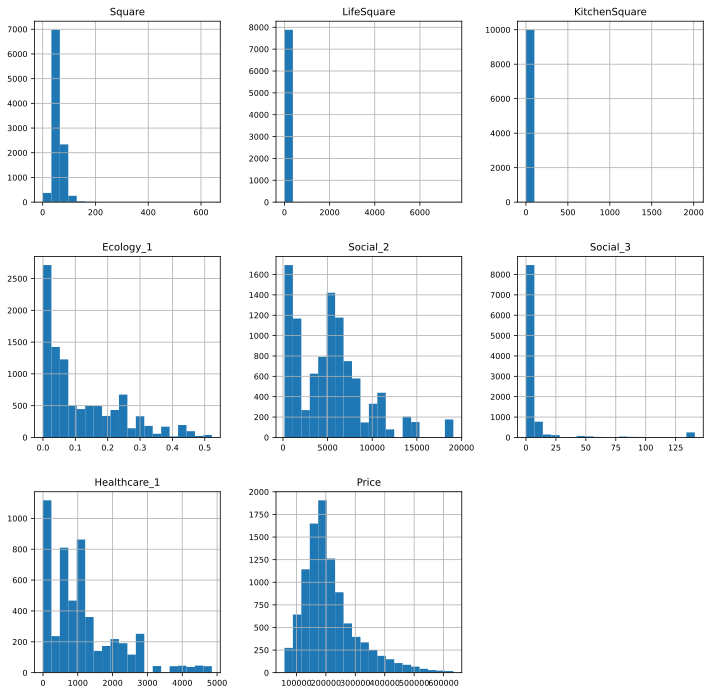

In [15]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

### b) Анализ номинальных переменных

In [16]:
df_cat_features = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'category'])
for col in df_cat_features:
        un_n = df[col].nunique()
        uniqset = np.array(df[col].unique())
        print(f'no of unique {col}: {un_n}')
        print(f'{np.sort(uniqset)} \n')

no of unique Id: 10000
[    0     2     5 ... 16796 16797 16798] 

no of unique District: 205
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 199
 200 201 202 205 207 208 209] 

no of unique Rooms: 9
[ 0  1  2  3  4  5  6 10 19] 

no of unique Floor

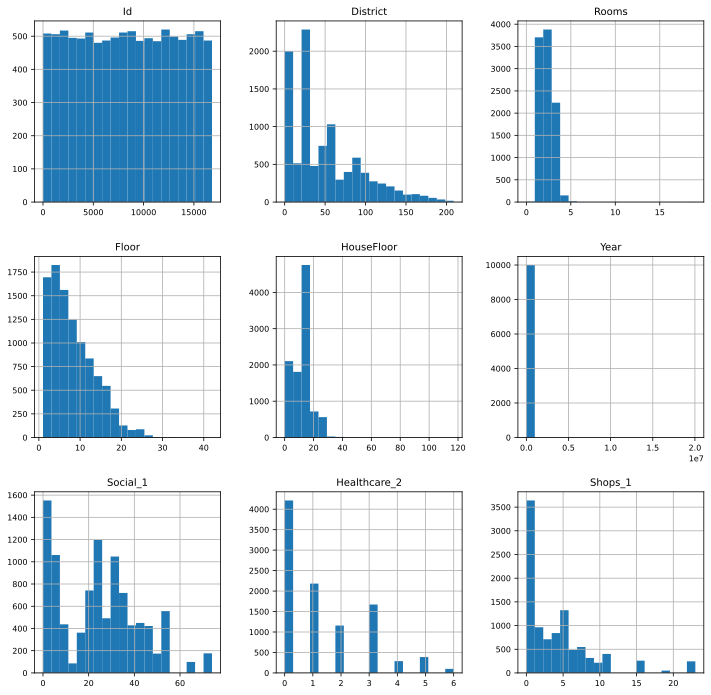

In [17]:
df_cat_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

# 5. Обработка аномалий

In [18]:
df.describe()

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Year,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.140625,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.817627,23.831953,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


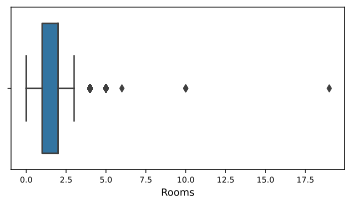

In [19]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['Rooms'], whis=1.5)
plt.xlabel('Rooms')
plt.show()

In [20]:
df.loc[df['Rooms'] > 6, 'Rooms'] = df['Rooms'].mode()[0]
df.loc[df['Rooms'] < 1, 'Rooms'] = df['Rooms'].mode()[0]

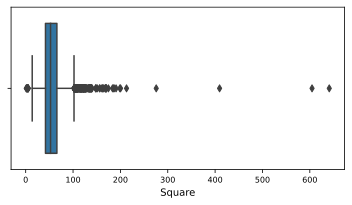

In [21]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['Square'], whis=1.5)
plt.xlabel('Square')
plt.show()

In [22]:
df.loc[df['Square'] > 120, 'Square'] = df['Square'].median()
df.loc[df['Square'] < 5, 'Square'] = df['Square'].median()

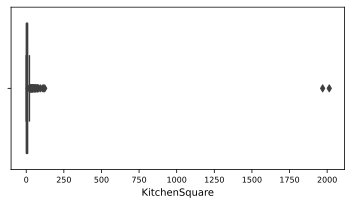

In [23]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['KitchenSquare'], whis=1.5)
plt.xlabel('KitchenSquare')
plt.show()

In [24]:
df.loc[df['KitchenSquare'] > 16, 'KitchenSquare'] = df['KitchenSquare'].median()
df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = df['KitchenSquare'].median()

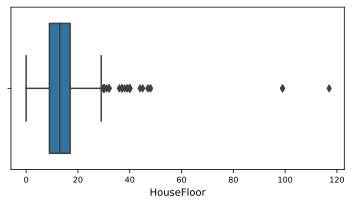

In [25]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['HouseFloor'], whis=1.5)
plt.xlabel('HouseFloor')
plt.show()

In [26]:
df.loc[df['HouseFloor'] > 40, 'HouseFloor'] = df['HouseFloor'].mode()[0]

In [27]:
df.loc[df['Floor'] > 40, 'Floor'] = df['Floor'].mode()[0]
df.loc[df['Year'] > 2020, 'Year'] = 2020
df.loc[df['Ecology_1'] == 0, 'Ecology_1'] = df['Ecology_1'].median()
df.loc[df['Social_1'] == 0, 'Social_1'] = df['Social_1'].mode()[0]
df.loc[df['Social_3'] == 0, 'Social_3'] = df['Social_3'].median()
df.loc[df['Healthcare_2'] == 0, 'Healthcare_2'] = df['Healthcare_2'].mode()[0]
df.loc[df['Shops_1'] == 0, 'Shops_1'] = df['Shops_1'].mode()[0]

# 6. Коррекция пропусков

In [28]:
df.isna().sum()

Id                  0
District            0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
Year                0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

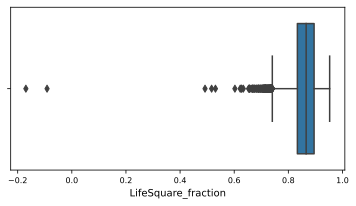

In [29]:
df['LifeSquare_fraction'] = 1 - df['KitchenSquare'] / df['Square']

plt.figure(figsize=(6, 3))
sns.boxplot(df['LifeSquare_fraction'], whis=1.5)
plt.xlabel('LifeSquare_fraction')
plt.show()

In [30]:
df.loc[df['LifeSquare_fraction'] < 0.7, 'LifeSquare_fraction'] = df['LifeSquare_fraction'].median()

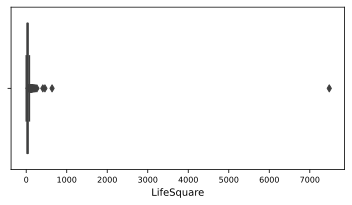

In [31]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')
plt.show()

In [32]:
df.loc[df['LifeSquare'] > 120, 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['LifeSquare'] < 6, 'LifeSquare'] = df['LifeSquare'].median()

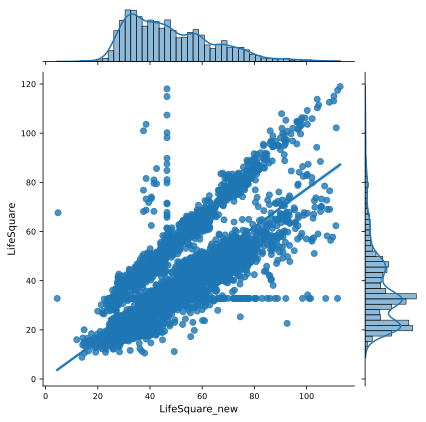

In [33]:
df['LifeSquare_new'] = df['LifeSquare_fraction'] * df['Square']

grid = sns.jointplot(df['LifeSquare_new'], df['LifeSquare'], kind='reg')
plt.show()

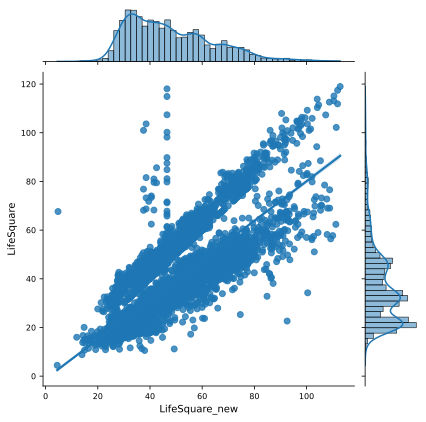

In [34]:
df.loc[df['LifeSquare'] == df['LifeSquare'].median(), 'LifeSquare'] = df['LifeSquare_new']

grid = sns.jointplot(df['LifeSquare_new'], df['LifeSquare'], kind='reg')
plt.show()

In [35]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['LifeSquare_new']
df.drop(['LifeSquare_new', 'LifeSquare_fraction'], inplace=True, axis=1)

df['Rooms'] = df['Rooms'].fillna(df['Rooms'].mode()[0])
df['HouseFloor'] = df['HouseFloor'].fillna(df['HouseFloor'].mode()[0])
df['Year'] = df['Year'].fillna(df['Year'].mode()[0])
df['Floor'] = df['Floor'].fillna(df['Floor'].mode()[0])

# 7. Генерация новых признаков

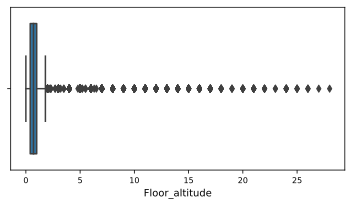

In [36]:
df['Floor_altitude'] = (df['Floor'] / df['HouseFloor']).round(decimals=1)

plt.figure(figsize=(6, 3))
sns.boxplot(df['Floor_altitude'], whis=1.5)
plt.xlabel('Floor_altitude')
plt.show()

In [37]:
df.loc[df['Floor_altitude'] > 1, 'Floor_altitude'] = df['Floor_altitude'].median()

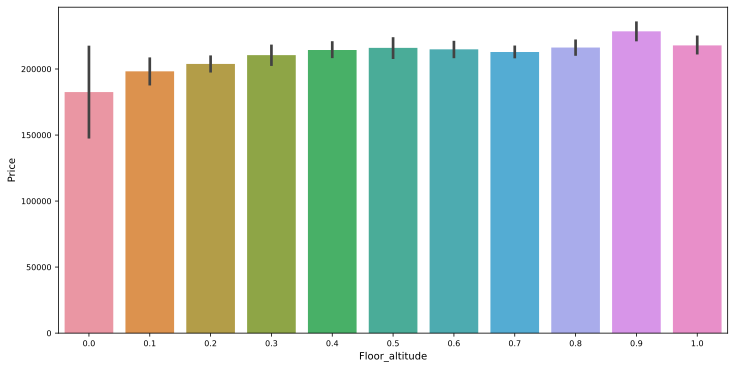

In [38]:
plt.figure(figsize = (12, 6))
sns.barplot(x='Floor_altitude', y='Price', data=df)
plt.show()

In [39]:
df['IsFirstFloor'] = (df['Floor_altitude'] < 0.2).astype(int)

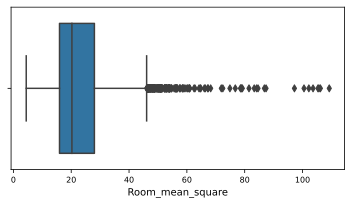

In [40]:
df['Room_mean_square'] = df['LifeSquare'] / df['Rooms']

plt.figure(figsize=(6, 3))
sns.boxplot(df['Room_mean_square'], whis=1.5)
plt.xlabel('Room_mean_square')
plt.show()

In [41]:
df.loc[df['Room_mean_square'] > 50, 'Room_mean_square'] = df['Room_mean_square'].median()
df.loc[df['Room_mean_square'] < 6, 'Room_mean_square'] = df['Room_mean_square'].median()

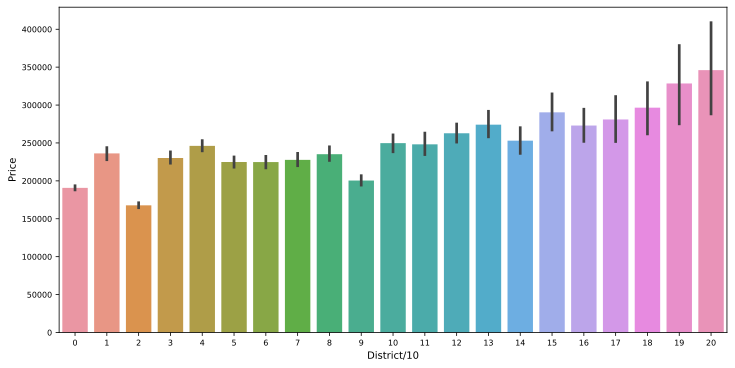

In [42]:
df['District/10'] = df['District'] // 10

plt.figure(figsize = (12, 6))
sns.barplot(x='District/10', y='Price', data=df)
plt.show()

In [43]:
district_size = df['District'].value_counts().reset_index()\
                    .rename(columns={'index':'District', 'District':'DistrictSize'})

df = df.merge(district_size, on='District', how='left')

In [44]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)

In [45]:
df['DistrictDensity'] = df['District'].map(df['DistrictSize'])

In [46]:
df['Price_per_square'] = (df['Price'] // df['Square'])

In [47]:
df_mean_price_dist = df.groupby('District').median()['Price_per_square'].round()
df_mean = pd.DataFrame(df_mean_price_dist)
df_mean.rename(columns = {'Price_per_square' : 'Median_Price_per_square'}, inplace = True)

In [48]:
df = df.merge(df_mean, on=['District'])

In [49]:
df['Year_expensive'] = 0
df.loc[df['Year'] <= 1955, 'Year_expensive'] = 10
df.loc[(df['Year'] > 1995) & (df['Year'] <= 2005), 'Year_expensive'] = 9
df.loc[(df['Year'] > 1985) & (df['Year'] <= 1995), 'Year_expensive'] = 8
df.loc[(df['Year'] > 1977) & (df['Year'] <= 1985), 'Year_expensive'] = 7
df.loc[df['Year'] == 1976, 'Year_expensive'] = 7
df.loc[(df['Year'] > 1955) & (df['Year'] <= 1965), 'Year_expensive'] = 6
df.loc[(df['Year'] > 2005) & (df['Year'] <= 2015), 'Year_expensive'] = 5
df.loc[(df['Year'] > 1970) & (df['Year'] <= 1975), 'Year_expensive'] = 4
df.loc[df['Year'] > 2015, 'Year_expensive'] = 3
df.loc[(df['Year'] > 1965) & (df['Year'] <= 1970), 'Year_expensive'] = 2
df.loc[df['Year'] == 1977, 'Year_expensive'] = 1

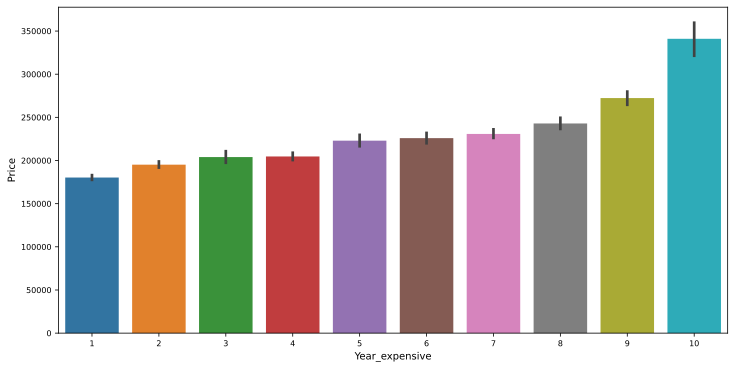

In [50]:
plt.figure(figsize = (12, 6))
sns.barplot(x='Year_expensive', y='Price', data=df)
plt.show()

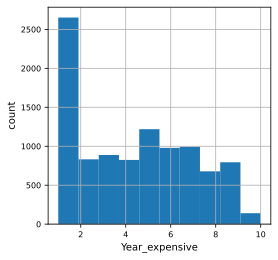

In [51]:
plt.figure(figsize = (4, 4))
df['Year_expensive'].hist(density=False, bins=10)
plt.ylabel('count')
plt.xlabel('Year_expensive')
plt.show()